# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import os

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
def show_dataset_shapes(dataloaders):
    """
    Prints the shapes of one batch of data from the train, validation, and test datasets.

    Args:
        dataloaders (dict): A dictionary containing DataLoader objects for 'train', 'valid', and 'test'.
    """
    for phase in ['train', 'valid', 'test']:
        dataiter = iter(dataloaders[phase])
        images, labels = next(dataiter)

        print(f"{phase.capitalize()} set:")
        print(f"  Images batch shape: {images.shape}")
        print(f"  Labels batch shape: {labels.shape}")
        print(f"  Number of samples: {len(dataloaders[phase].dataset)}")
        print()


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

# batch size
batch_size = 128

# determine the device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Transform data for use in neural networks.

# define data augmentation and normalization transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # Augment training data to improve robustness of neural networks.
    transforms.RandomHorizontalFlip(), # Augment training data to improve robustness of neural networks.
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # recommended normalize values for IFAR10
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

# split the training set into train, validation and testing sets
train_size = int(0.8 * len(trainset))
valid_size = len(trainset) - train_size

trainset, validset = random_split(trainset, [train_size, valid_size])

# Use DataLoader to feed training data to PyTorch models.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

# define validation dataloader
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=False, num_workers=4)

# create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

# Update dataloaders and dataset sizes dictionaries
dataloaders = {'train': trainloader, 'valid': validloader, 'test': testloader}
dataset_sizes = {'train': len(trainset), 'valid': len(validset), 'test': len(testset)}

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print()
# Explore datasets and describe their properties to set and optimize neural network parameters.
show_dataset_shapes(dataloaders)


Files already downloaded and verified
Files already downloaded and verified

Train set:
  Images batch shape: torch.Size([128, 3, 32, 32])
  Labels batch shape: torch.Size([128])
  Number of samples: 40000

Valid set:
  Images batch shape: torch.Size([128, 3, 32, 32])
  Labels batch shape: torch.Size([128])
  Number of samples: 10000

Test set:
  Images batch shape: torch.Size([128, 3, 32, 32])
  Labels batch shape: torch.Size([128])
  Number of samples: 10000



## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    
    # Mean and std for the CIFAR-10 dataset
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])

    for i in range(len(images)):
        print("Label: " + classes[labels[i]])
    
        image = images[i].numpy()
        
        # Denormalise
        for channel in range(3):  # iterate over color channels
            image[channel] = image[channel] * std[channel] + mean[channel]
                
        image = np.clip(image, 0, 1)
        
        # Transpose (von PyTorch(C, H, W) zu Numpy(H, W, C))
        image = np.transpose(image, (1, 2, 0))
        
        plt.figure(figsize=(1, 1))
        plt.axis('off')
        plt.imshow(image)
        plt.show()

Label: cat


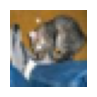

Label: ship


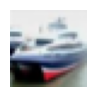

Label: ship


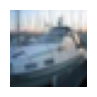

Label: plane


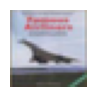

Label: frog


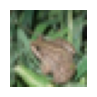

In [6]:
# Explore datasets and describe their properties to set and optimize neural network parameters.
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

Lets try something simple first. A "classic" **CNN** aproach.

In [23]:
# Use PyTorch to build a neural network for image classification.
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes) # no explicit activation function here because a soft max is integrated in CrossEntropyLoss
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv1(x), 2))
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv2(x), 2))
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv3(x), 2))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Lets try a more advanced model.

In [7]:
# Use PyTorch to build a neural network for image classification.
class AdvancedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AdvancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes) # no explicit activation function here because a soft max is integrated in CrossEntropyLoss
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv1(x), 2))
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv2(x), 2))
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv3(x), 2))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN(num_classes=10).to(device) 
model = model.to(device)

# Select a loss function for training a classification network.
criterion = nn.CrossEntropyLoss()

# Define an optimizer to minimize loss function and update model parameters for improved accuracy.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# override the learning rate of the default optimizer and integrate a StepLR strategy (because I wanted to test that too)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print(model)

# you can load a previously saved model here
if os.path.exists("checkpoint/checkpoint.pth"):
    start_epoch, criterion = load_checkpoint(model, optimizer, 'checkpoint/checkpoint.pth')
else:
    start_epoch = 0

#start_epoch = 0
print(f"Start/Continue with epoch: {start_epoch}")

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Start/Continue with epoch: 0


In [10]:
# Train a neural network using PyTorch to achieve a given level of accuracy.
def train_model(model, criterion, optimizer, scheduler, start_epoch=0, num_epochs=20, patience=5, min_delta=0.001):
    since = time.time()

    # lets deep copy the current model so we can return the model with the highest accuracy later on
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0
    
    train_losses = []
    valid_losses = []
    
    for epoch in range(start_epoch, num_epochs + start_epoch):
        print(f'Epoch {epoch}/{num_epochs  + start_epoch - 1}')
        print('-' * 10)

        # time measure for epoch
        epoch_since = time.time()
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # save the losses for plotting it later
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                valid_losses.append(epoch_loss)
                
            # validation Loss and Accuracy
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # check for improvement in validation phase
            if phase == 'valid':
                if epoch_acc > best_acc + min_delta:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        # early stopping
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {patience} epochs with no improvement.')
            break

        epoch_time_elapsed = time.time() - epoch_since
        print(f'Epoch {epoch} complete in {epoch_time_elapsed // 60:.0f}m {epoch_time_elapsed % 60:.0f}s')
        print()

    # validation Loss and Accuracy
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # return the best (most accurate) model
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

**Remarks** to Loss Function:

I think CrossEntropyLoss is not so exotic, so I am going to try it with that loss function type first. Please be **aware** of the fact, that no explicit soft-max activation function needs to be defined in the output layer if CrossEntropyLoss is used. CrossEntropyLoss already implements a soft-max.

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [25]:
# Train a neural network using PyTorch to achieve a given level of accuracy.
trained_model, train_loss, valid_loss = train_model(model, criterion, optimizer, scheduler, start_epoch=start_epoch, num_epochs=20, patience=5)

Epoch 0/19
----------
train Loss: 1.6723 Acc: 0.3864
valid Loss: 1.4085 Acc: 0.4779
Epoch 0 complete in 0m 4s

Epoch 1/19
----------
train Loss: 1.3459 Acc: 0.5148
valid Loss: 1.1949 Acc: 0.5707
Epoch 1 complete in 0m 3s

Epoch 2/19
----------
train Loss: 1.1875 Acc: 0.5746
valid Loss: 1.0702 Acc: 0.6101
Epoch 2 complete in 0m 3s

Epoch 3/19
----------
train Loss: 1.0769 Acc: 0.6116
valid Loss: 1.0202 Acc: 0.6289
Epoch 3 complete in 0m 3s

Epoch 4/19
----------
train Loss: 1.0004 Acc: 0.6424
valid Loss: 0.9227 Acc: 0.6751
Epoch 4 complete in 0m 3s

Epoch 5/19
----------
train Loss: 0.9474 Acc: 0.6633
valid Loss: 0.8814 Acc: 0.6916
Epoch 5 complete in 0m 3s

Epoch 6/19
----------
train Loss: 0.9027 Acc: 0.6784
valid Loss: 0.8167 Acc: 0.7152
Epoch 6 complete in 0m 3s

Epoch 7/19
----------
train Loss: 0.8118 Acc: 0.7134
valid Loss: 0.7667 Acc: 0.7355
Epoch 7 complete in 0m 3s

Epoch 8/19
----------
train Loss: 0.7910 Acc: 0.7192
valid Loss: 0.7479 Acc: 0.7401
Epoch 8 complete in 0m 3s

E

Plot the training loss (and validation loss/accuracy, if recorded).

In [12]:
def plot_losses(train_losses, valid_losses):
    """
    Plots the training and validation losses over epochs.

    Args:
        train_losses (list): List of training losses recorded at the end of each epoch.
        valid_losses (list): List of validation losses recorded at the end of each epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

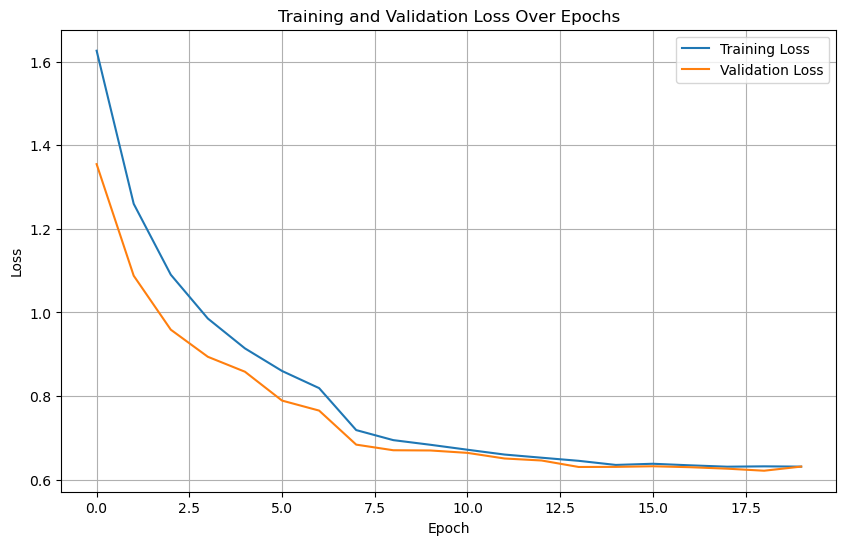

In [13]:
# Compute and plot average loss to track model performance.
plot_losses(train_loss, valid_loss)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [14]:
def evaluate_model(model, dataloader, criterion, device):
    """
    Evaluates the model on the test set.

    Args:
        model (nn.Module): The model to evaluate.
        dataloader (torch.utils.data.DataLoader): The dataloader for the test set.
        criterion (nn.CrossEntropyLoss): The loss function.
        device (torch.device): The device to evaluate on (CPU/GPU).

    Returns:
        None
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(dataloader.dataset)
    total_acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Test Loss: {total_loss:.4f} Acc: {total_acc:.4f}')

In [15]:
# Use DataLoaders to test the accuracy of a model.
print("\nEvaluating the model on the test set...")
evaluate_model(model, dataloaders['test'], criterion, device)


Evaluating the model on the test set...
Test Loss: 0.5862 Acc: 0.7990


## Loading existing model

In [19]:
import torch
import os

def load_checkpoint(model, optimizer, checkpoint_path):
    """
    Loads the state of the model, optimizer, and other relevant information from a checkpoint file.

    Args:
        model (nn.Module): The model to load the state into.
        optimizer (optim.Adam): The optimizer to load the state into.
        checkpoint_path (str): The path to the checkpoint file.
    
    Returns:
        int: The epoch at which the checkpoint was saved.
        float: The learning rate at which the checkpoint was saved.
    """
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found at '{checkpoint_path}'")

    checkpoint = torch.load(checkpoint_path)
    
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # load criterion if present
    if 'criterion' in checkpoint:
        criterion = nn.CrossEntropyLoss()
        criterion.load_state_dict(checkpoint['criterion'])
    else:
        criterion = None

    # return learning rate and epoch
    return checkpoint['epoch'], criterion

## Saving your model
Using `torch.save`, save your model for future loading.

In [16]:
# Save trained model parameters for later use.
def save_checkpoint(model, optimizer, save_dir, epoch, criterion):
    """
    Saves the current state of the model, optimizer, and other relevant information to a checkpoint file.

    Args:
        model (nn.Module): The model to save.
        optimizer (optim.Adam): The optimizer to save.
        save_dir (str): The directory to save the checkpoint file in.
        epoch (int): The current epoch.        
        criterion (nn.CrossEntropyLoss): The loss function to save.
    """
    checkpoint = {
        'epoch': epoch,        
        'state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),        
        'criterion': criterion.state_dict(),
        #'learning_rate': learning_rate
    }
    
    torch.save(checkpoint, os.path.join(save_dir, 'checkpoint.pth'))

In [17]:
save_checkpoint(model, optimizer, "./checkpoint", 20, criterion)

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

The network configured in-house (AdvancedCNN) achieves an accuracy of approx. 78%. That is 8% more than the solution from Detectorcorp. And that after just 20 epochs of training. Of course, the self-built solution stagnates at around 78%, but if that is sufficient, then you can rely on an in-house solution. With more time and computing resources and more complex architectures, you can certainly get even more out of it.

**My advice:**


I would therefore advise against buying a network from Detectorcorp.

